In [1]:
import os
from pathlib import Path

import numpy as np
import pandas as pd
import anndata
import scanpy as sc
from scipy.io import mmread
from scipy.sparse import csr_matrix

import scanpy.external as sce






## prostate

In [2]:
# Load sparse matrix
X = mmread("../data/single-cell/prostate_counts.mtx").tocsr()

# Load metadata
genes = pd.read_csv("../data/single-cell/gene_metadata.csv", index_col=0)
cells = pd.read_csv("../data/single-cell/cell_metadata.csv", index_col=0)


adata = anndata.AnnData(X=X.T, var=genes, obs=cells)
adata

AnnData object with n_obs × n_vars = 56111 × 36601
    obs: 'orig.ident', 'dotcat', 'celltypes'
    var: 'counts'

In [3]:
np.unique(adata.X[0, :].toarray())

array([  0,   1,   2,   3,   4,   5,   6,   7,   8,   9,  10,  11,  12,
        13,  14,  15,  16,  17,  20,  23,  26,  27, 259])

In [4]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True
)
adata

AnnData object with n_obs × n_vars = 56111 × 36601
    obs: 'orig.ident', 'dotcat', 'celltypes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb'
    var: 'counts', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'

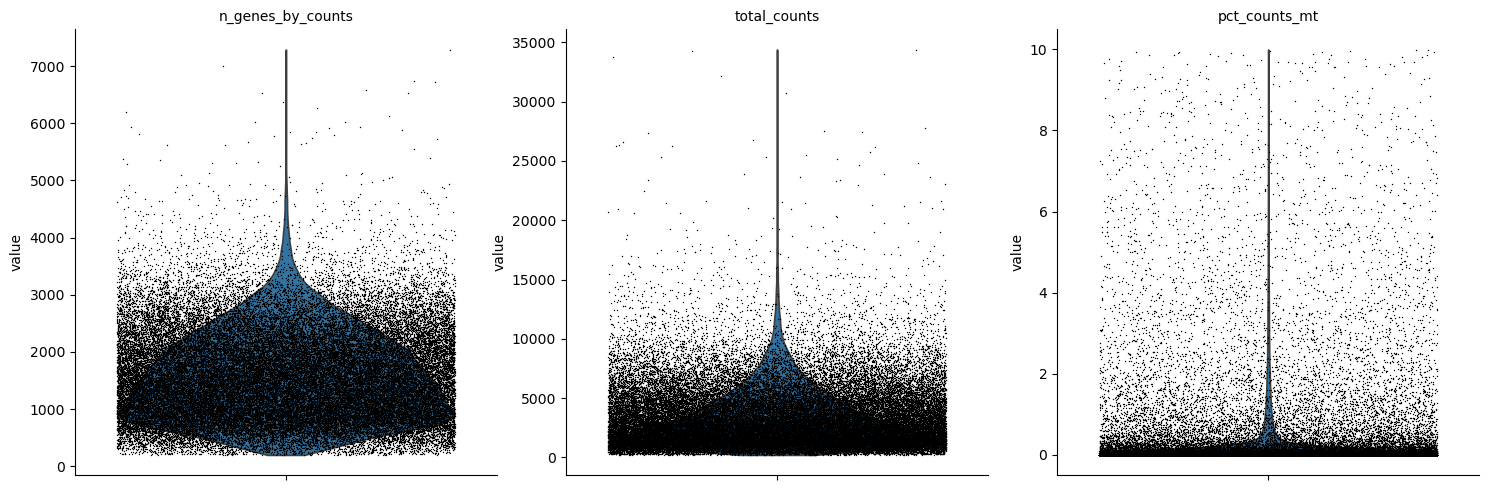

In [5]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [6]:
# have probably already been filtere by others
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [7]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="orig.ident")

In [8]:
sc.tl.pca(adata)


In [9]:
sce.pp.harmony_integrate(adata, "orig.ident")

2025-06-04 21:39:48,314 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-04 21:41:30,111 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-04 21:41:30,659 - harmonypy - INFO - Iteration 1 of 10
2025-06-04 21:42:24,196 - harmonypy - INFO - Iteration 2 of 10
2025-06-04 21:43:15,714 - harmonypy - INFO - Converged after 2 iterations


In [12]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

In [18]:
sc.tl.leiden(adata)

/tmp/43145.tmpdir/ipykernel_397/3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


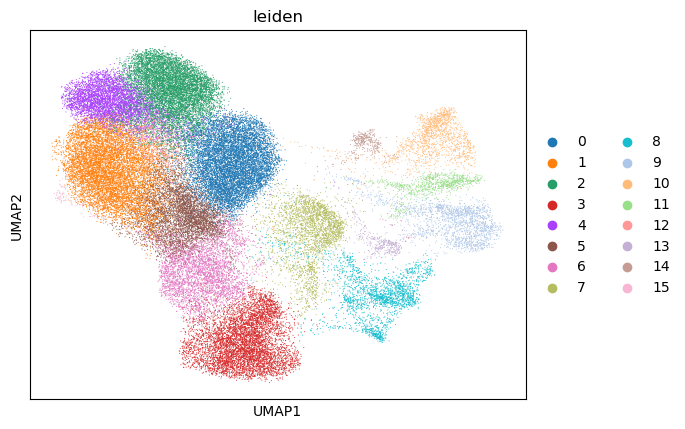

In [28]:
sc.pl.umap(adata, color='leiden')

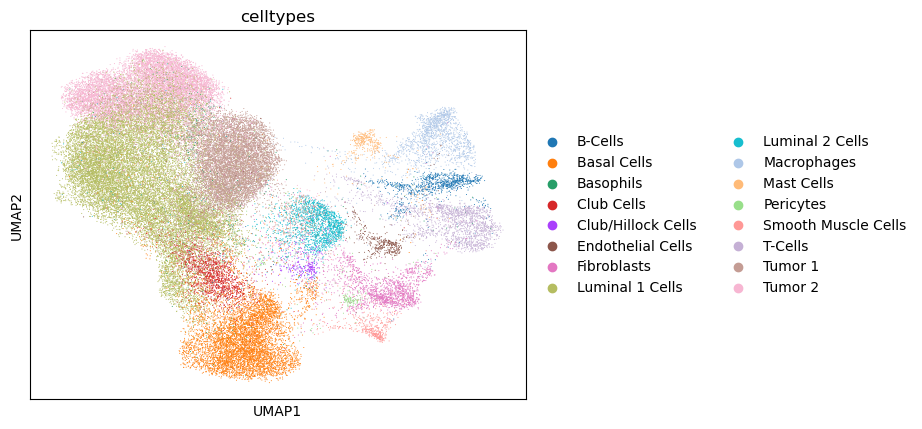

In [21]:
sc.pl.umap(adata, color='celltypes')

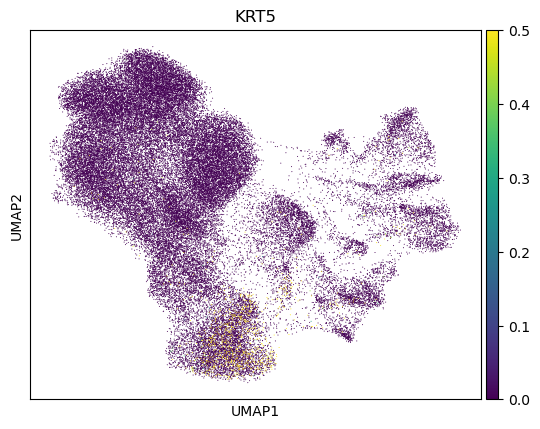

In [27]:
sc.pl.umap(adata, color='KRT5', vmax=.5)

In [20]:
adata

AnnData object with n_obs × n_vars = 56111 × 30865
    obs: 'orig.ident', 'dotcat', 'celltypes', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'total_counts_mt', 'log1p_total_counts_mt', 'pct_counts_mt', 'total_counts_ribo', 'log1p_total_counts_ribo', 'pct_counts_ribo', 'total_counts_hb', 'log1p_total_counts_hb', 'pct_counts_hb', 'n_genes', 'leiden'
    var: 'counts', 'mt', 'ribo', 'hb', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts', 'n_cells', 'highly_variable', 'means', 'dispersions', 'dispersions_norm', 'highly_variable_nbatches', 'highly_variable_intersection'
    uns: 'log1p', 'hvg', 'pca', 'neighbors', 'umap', 'leiden', 'leiden_colors'
    obsm: 'X_pca', 'X_pca_harmony', 'X_umap'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'distances', 'connecti

In [35]:
# Obtain cluster-specific differentially expressed genes
def labeler(x):
    if x in ['Luminal 1 Cells', 'Luminal 2 Cells', 'Tumor 1', 'Tumor 2']:
        return 'reference'
    if x == 'Basal Cells':
        return 'Basal Cells'
    return 'other'
adata.obs['reference_group'] = [labeler(c) for c in adata.obs['celltypes']]
sc.tl.rank_genes_groups(adata, groupby="reference_group", method="wilcoxon", reference='reference')


In [38]:
degs = sc.get.rank_genes_groups_df(adata, group="Basal Cells")
degs

names      scores  logfoldchanges  pvals  pvals_adj
0         MEIS2   98.328201        5.051916    0.0        0.0
1      MIR205HG   91.886780        8.452617    0.0        0.0
2         PCDH7   78.717873        6.919479    0.0        0.0
3         RBMS3   77.533699        3.028224    0.0        0.0
4           MCC   76.949448        3.737141    0.0        0.0
...         ...         ...             ...    ...        ...
30860   TMPRSS2 -106.596954       -4.108202    0.0        0.0
30861      AFF3 -112.303261       -5.140292    0.0        0.0
30862     CPNE4 -112.510956       -5.191432    0.0        0.0
30863      KLK2 -113.057114       -4.934494    0.0        0.0
30864      KLK3 -113.811974       -4.955718    0.0        0.0

[30865 rows x 5 columns]

In [37]:
adata.write_h5ad('../data/single-cell/prostate.h5ad')

In [40]:
degs.to_csv('../data/single-cell/degs/prostate.txt', sep='\t', index=False)

## breast

In [2]:
adata = sc.read_h5ad('../data/single-cell/orig_breast.h5ad')
adata

AnnData object with n_obs × n_vars = 131348 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type_final', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_ATAC_MACS2', 'nFeature_ATAC_MACS2', 'pct_read_in_peaks_500

In [3]:
adata.X = adata.raw.X

In [4]:
np.unique(adata.X[0].toarray())

array([  0.,   1.,   2.,   3.,   4.,   5.,   6.,   7.,   8.,   9.,  10.,
        11.,  12.,  13.,  14.,  15.,  16.,  17.,  18.,  19.,  20.,  21.,
        22.,  23.,  24.,  25.,  29.,  30.,  31.,  32.,  34.,  37.,  40.,
        47.,  50.,  58.,  59.,  82.,  92., 455.])

In [5]:
# mitochondrial genes, "MT-" for human, "Mt-" for mouse
adata.var["mt"] = adata.var_names.str.startswith("MT-")
# ribosomal genes
adata.var["ribo"] = adata.var_names.str.startswith(("RPS", "RPL"))
# hemoglobin genes
adata.var["hb"] = adata.var_names.str.contains("^HB[^(P)]")

sc.pp.calculate_qc_metrics(
    adata, qc_vars=["mt", "ribo", "hb"], inplace=True
)
adata

AnnData object with n_obs × n_vars = 131348 × 36601
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'percent.mito', 'nCount_SCT', 'nFeature_SCT', 'SCT_snn_res.0.5', 'seurat_clusters', 'cell_type_final', 'is_cell', 'excluded_reason', 'gex_raw_reads', 'gex_mapped_reads', 'gex_conf_intergenic_reads', 'gex_conf_exonic_reads', 'gex_conf_intronic_reads', 'gex_conf_exonic_unique_reads', 'gex_conf_exonic_antisense_reads', 'gex_conf_exonic_dup_reads', 'gex_exonic_umis', 'gex_conf_intronic_unique_reads', 'gex_conf_intronic_antisense_reads', 'gex_conf_intronic_dup_reads', 'gex_intronic_umis', 'gex_conf_txomic_unique_reads', 'gex_umis_count', 'gex_genes_count', 'atac_raw_reads', 'atac_unmapped_reads', 'atac_lowmapq', 'atac_dup_reads', 'atac_chimeric_reads', 'atac_mitochondrial_reads', 'atac_fragments', 'atac_TSS_fragments', 'atac_peak_region_fragments', 'atac_peak_region_cutsites', 'percent.mt', 'nCount_ATAC', 'nFeature_ATAC', 'nCount_ATAC_MACS2', 'nFeature_ATAC_MACS2', 'pct_read_in_peaks_500

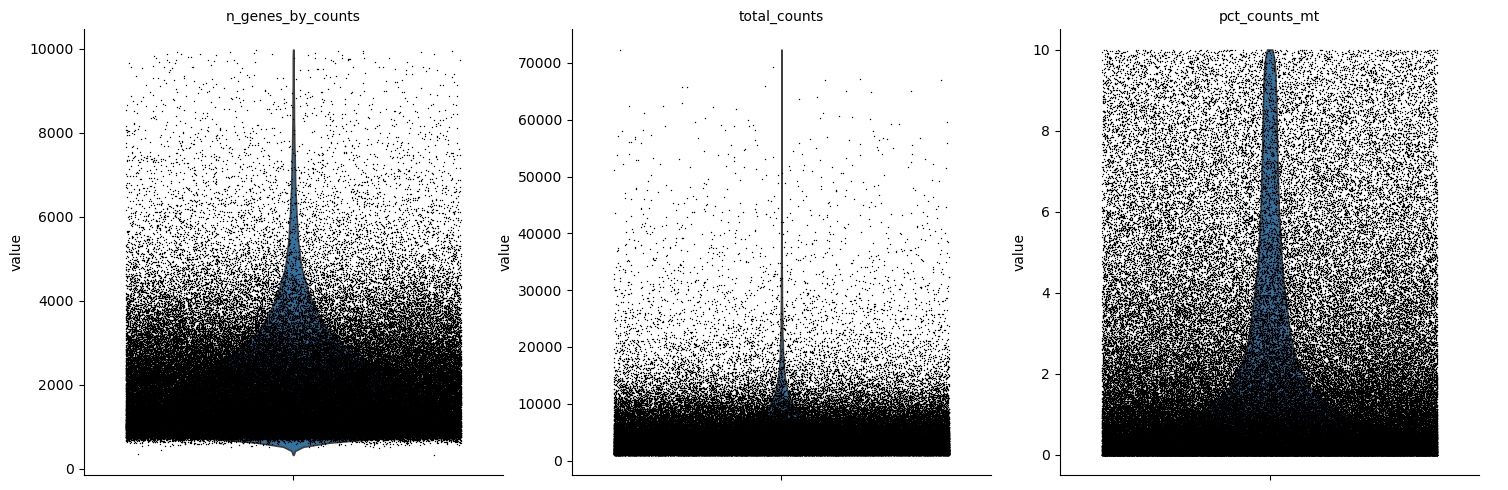

In [6]:
sc.pl.violin(
    adata,
    ["n_genes_by_counts", "total_counts", "pct_counts_mt"],
    jitter=0.4,
    multi_panel=True,
)

In [7]:
# have probably already been filtere by others
sc.pp.filter_cells(adata, min_genes=100)
sc.pp.filter_genes(adata, min_cells=3)

In [8]:
# Saving count data
adata.layers["counts"] = adata.X.copy()

# Normalizing to median total counts
sc.pp.normalize_total(adata)
# Logarithmize the data
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(adata, n_top_genes=2000, batch_key="orig.ident")

In [9]:
sc.tl.pca(adata)


In [10]:
sce.pp.harmony_integrate(adata, "orig.ident")

2025-06-09 19:08:04,602 - harmonypy - INFO - Computing initial centroids with sklearn.KMeans...
2025-06-09 19:09:25,065 - harmonypy - INFO - sklearn.KMeans initialization complete.
2025-06-09 19:09:25,801 - harmonypy - INFO - Iteration 1 of 10
2025-06-09 19:11:47,326 - harmonypy - INFO - Iteration 2 of 10
2025-06-09 19:14:03,920 - harmonypy - INFO - Iteration 3 of 10
2025-06-09 19:16:21,519 - harmonypy - INFO - Iteration 4 of 10
2025-06-09 19:18:41,954 - harmonypy - INFO - Converged after 4 iterations


In [11]:
sc.pp.neighbors(adata, use_rep='X_pca_harmony')
sc.tl.umap(adata)

In [12]:
sc.tl.leiden(adata)

/tmp/43145.tmpdir/ipykernel_763/3467744858.py:1: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata)


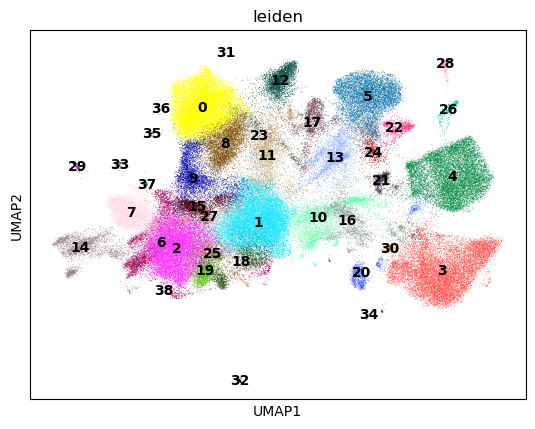

In [13]:
sc.pl.umap(adata, color='leiden', legend_loc='on data')

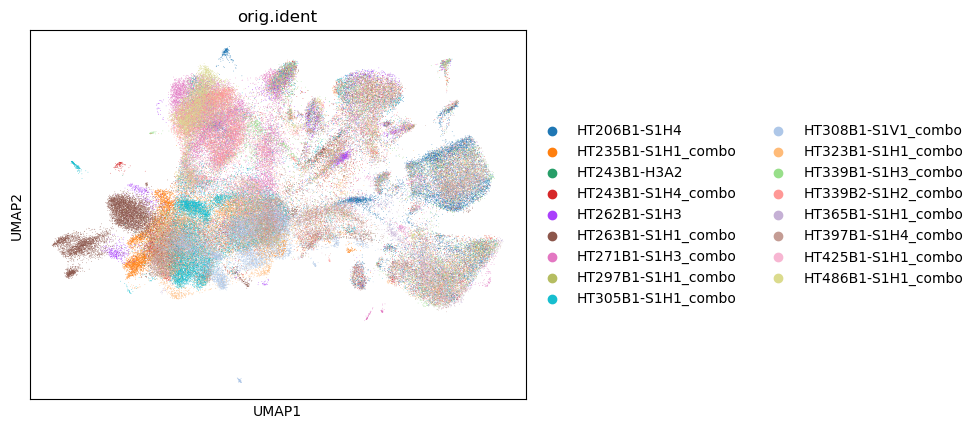

In [14]:
sc.pl.umap(adata, color='orig.ident')

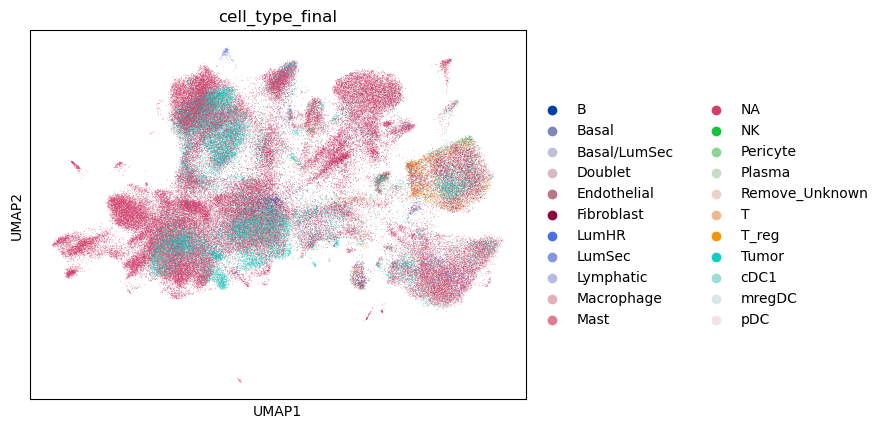

In [15]:
sc.pl.umap(adata, color='cell_type_final')

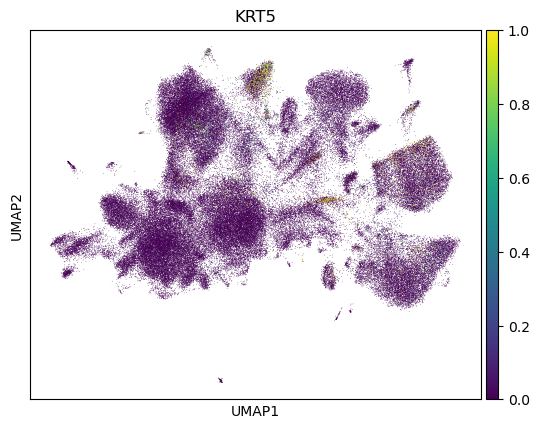

In [16]:
sc.pl.umap(adata, color=['KRT5'], use_raw=False, vmax=1)

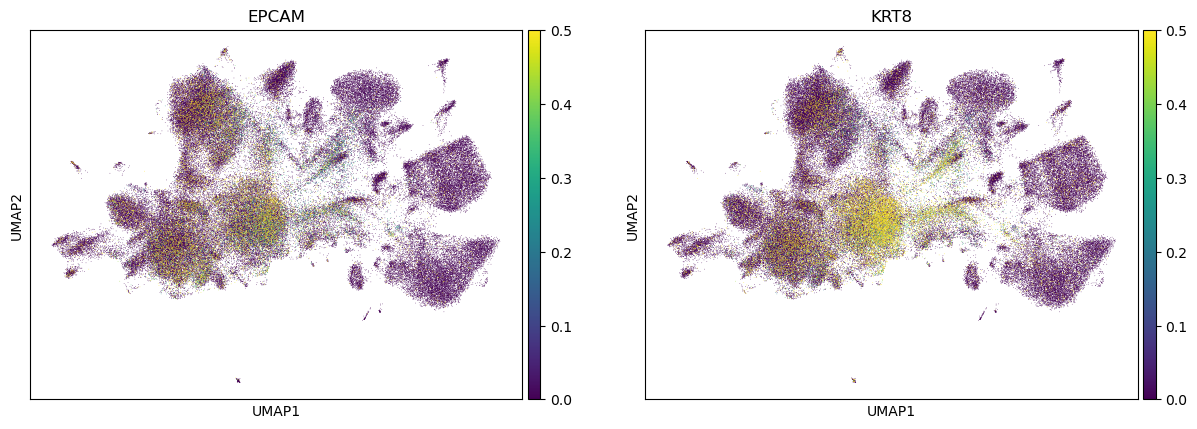

In [17]:
sc.pl.umap(adata, color=['EPCAM', 'KRT8'], use_raw=False, vmax=.5)

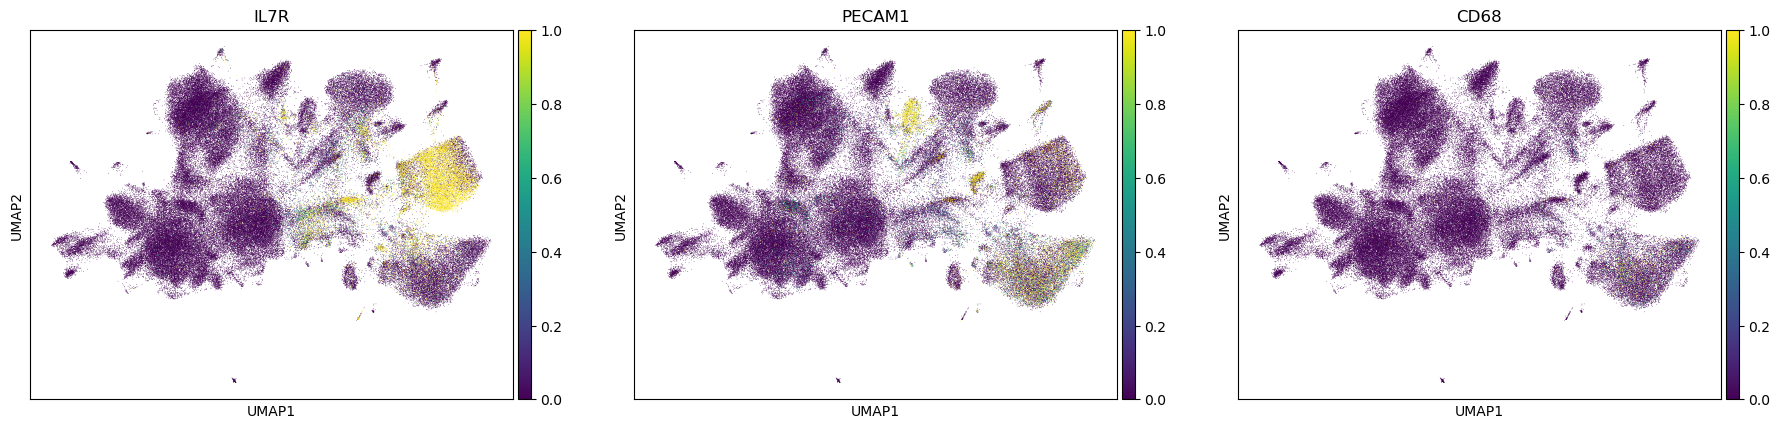

In [18]:
sc.pl.umap(adata, color=['IL7R', 'PECAM1', 'CD68'], use_raw=False, vmax=1)

In [19]:
is_tnbc = [
    'HT206B1-S1H4',
    'HT271B1-S1H3_combo',
    'HT339B1-S1H3_combo',
    'HT339B2-S1H2_combo',
]
adata.obs['is_tnbc'] = [x in is_tnbc for x in adata.obs['orig.ident']]

In [22]:
mapping = {
    'Basal Cells': [12],
    'Luminal/Tumor Cells': [14, 7, 37, 6, 2, 38, 19, 25, 18, 1, 27, 15, 9, 23, 8, 0],
}
r_mapping = {v:k for k, vs in mapping.items() for v in vs}
adata.obs['cell_type'] = [r_mapping.get(int(x), 'other') for x in adata.obs['leiden']]

ERROR! Session/line number was not unique in database. History logging moved to new session 589


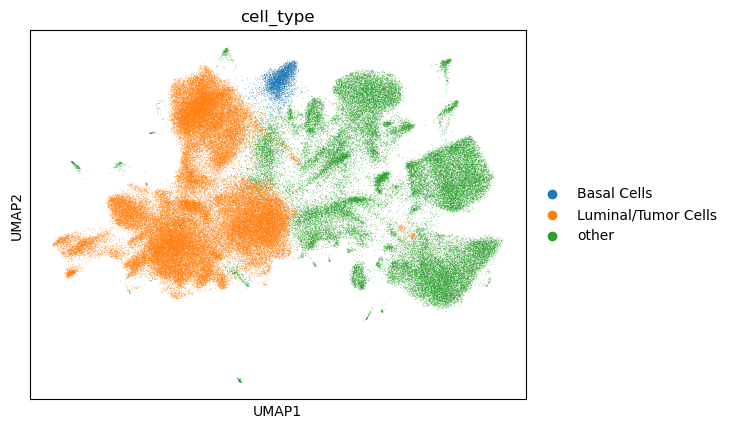

In [23]:
sc.pl.umap(adata, color=['cell_type'], use_raw=False, vmax=1)

In [24]:
sc.tl.rank_genes_groups(adata, groupby="cell_type", method="wilcoxon", reference='Luminal/Tumor Cells', use_raw=False)


In [25]:
degs = sc.get.rank_genes_groups_df(adata, group="Basal Cells")
degs

names     scores  logfoldchanges  pvals  pvals_adj
0           DMD  84.589119        4.839778    0.0        0.0
1         CALD1  79.198662        4.038258    0.0        0.0
2           DST  73.885811        3.369953    0.0        0.0
3         RBMS3  71.332375        4.024954    0.0        0.0
4      MIR205HG  70.113762        3.999832    0.0        0.0
...         ...        ...             ...    ...        ...
34149      VAV3 -50.637283       -2.512078    0.0        0.0
34150     TRPS1 -54.589130       -1.622143    0.0        0.0
34151      ESR1 -55.329502       -4.665419    0.0        0.0
34152     ERBB4 -58.058411       -3.818392    0.0        0.0
34153      TTC6 -59.109173       -5.580010    0.0        0.0

[34154 rows x 5 columns]

In [32]:
adata.obs

orig.ident nCount_RNA  \
HT206B1-S1H4_AAACCCACAGATTCGT-1              HT206B1-S1H4      14951   
HT206B1-S1H4_AAACCCACAGGCATTT-1              HT206B1-S1H4       2964   
HT206B1-S1H4_AAACCCACATGACGTT-1              HT206B1-S1H4       2585   
HT206B1-S1H4_AAACCCAGTCCTACAA-1              HT206B1-S1H4       1662   
HT206B1-S1H4_AAACCCAGTCTAGTGT-1              HT206B1-S1H4       1290   
...                                                   ...        ...   
HT486B1-S1H1_combo_TTTGTGGCATTAAACC-1  HT486B1-S1H1_combo       1582   
HT486B1-S1H1_combo_TTTGTGTTCATTGACA-1  HT486B1-S1H1_combo       5713   
HT486B1-S1H1_combo_TTTGTGTTCATTTGTC-1  HT486B1-S1H1_combo      23435   
HT486B1-S1H1_combo_TTTGTGTTCGATTATG-1  HT486B1-S1H1_combo       1825   
HT486B1-S1H1_combo_TTTGTTGGTGTTGTAG-1  HT486B1-S1H1_combo      15007   

                                      nFeature_RNA          percent.mito  \
HT206B1-S1H4_AAACCCACAGATTCGT-1               5706  0.000535081265467193   
HT206B1-S1H4_AAACCCACAGGCATTT-1               1550    0.0823211875843455   
HT206B1-S1H4_AAACCCACATGACGTT-1               1596    0.0421663442940039   
HT206B1-S1H4_AAACCCAGTCCTACAA-1               1120   0.00842358604091456   
HT206B1-S1H4_AAACCCAGTCTAGTGT-1                969    0.0124031007751938   
...                                            ...                   ...   
HT486B1-S1H1_combo_TTTGTGGCATTAAACC-1          987                    NA   
HT486B1-S1H1_combo_TTTGTGTTCATTGACA-1         2166                    NA   
HT486B1-S1H1_combo_TTTGTGTTCATTTGTC-1         5935                    NA   
HT486B1-S1H1_combo_TTTGTGTTCGATTATG-1          950                    NA   
HT486B1-S1H1_combo_TTTGTTGGTGTTGTAG-1         4568                    NA   

                                      nCount_SCT nFeature_SCT SCT_snn_res.0.5  \
HT206B1-S1H4_AAACCCACAGATTCGT-1             3405         2489               1   
HT206B1-S1H4_AAACCCACAGGCATTT-1             2999         1550               1   
HT206B1-S1H4_AAACCCACATGACGTT-1             2743         1596               2   
HT206B1-S1H4_AAACCCAGTCCTACAA-1             2697         1121              13   
HT206B1-S1H4_AAACCCAGTCTAGTGT-1             2609          978               2   
...                                          ...          ...             ...   
HT486B1-S1H1_combo_TTTGTGGCATTAAACC-1       2661          992              NA   
HT486B1-S1H1_combo_TTTGTGTTCATTGACA-1       3855         2097              NA   
HT486B1-S1H1_combo_TTTGTGTTCATTTGTC-1       3292         1939              NA   
HT486B1-S1H1_combo_TTTGTGTTCGATTATG-1       2639          950              NA   
HT486B1-S1H1_combo_TTTGTTGGTGTTGTAG-1       3425         1939              NA   

                                      seurat_clusters cell_type_final is_cell  \
HT206B1-S1H4_AAACCCACAGATTCGT-1                    15               T      NA   
HT206B1-S1H4_AAACCCACAGGCATTT-1                     9               T      NA   
HT206B1-S1H4_AAACCCACATGACGTT-1                     9               T      NA   
HT206B1-S1H4_AAACCCAGTCCTACAA-1                     9              NK      NA   
HT206B1-S1H4_AAACCCAGTCTAGTGT-1                     9               T      NA   
...                                               ...             ...     ...   
HT486B1-S1H1_combo_TTTGTGGCATTAAACC-1              22              NA       1   
HT486B1-S1H1_combo_TTTGTGTTCATTGACA-1              11              NA       1   
HT486B1-S1H1_combo_TTTGTGTTCATTTGTC-1              11              NA       1   
HT486B1-S1H1_combo_TTTGTGTTCGATTATG-1              11              NA       1   
HT486B1-S1H1_combo_TTTGTTGGTGTTGTAG-1              11              NA       1   

                                       ... total_counts_ribo  \
HT206B1-S1H4_AAACCCACAGATTCGT-1        ...             223.0   
HT206B1-S1H4_AAACCCACAGGCATTT-1        ...              25.0   
HT206B1-S1H4_AAACCCACATGACGTT-1        ...              98.0   
HT206B1-S1H4_AAACCCAGTCCTACAA-1        ...              27.0   
HT2

In [38]:
adata.raw = None
adata.write_h5ad('../data/single-cell/breast.h5ad')

degs.to_csv('../data/single-cell/degs/breast.txt', sep='\t', index=False)